## Train model for all glaciers, blocking by glacier


In [2]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt

from model_functions import select_variables
from model_functions import train_xgb_model

In [3]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-06-27_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)


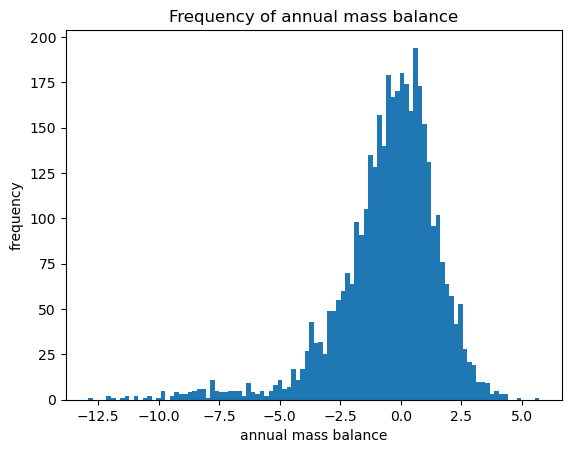

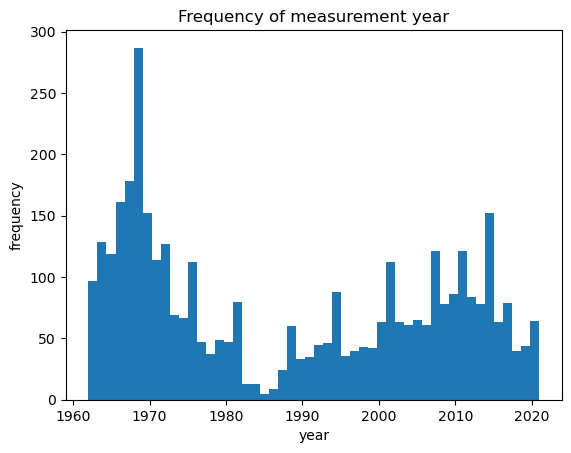

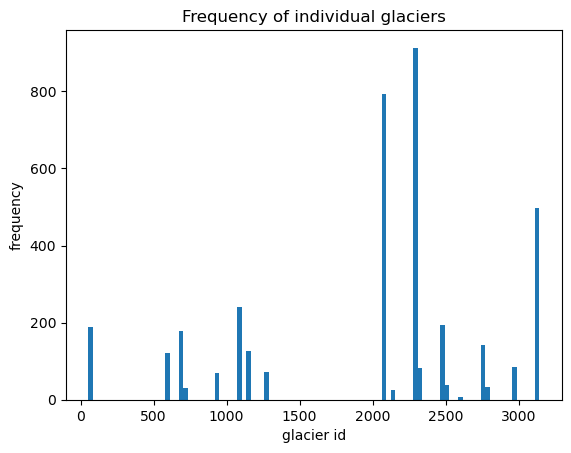

In [4]:
plt.figure()
glacier_data_all['balance_netto'].plot.hist(bins=100)
plt.title('Frequency of annual mass balance')
plt.ylabel('frequency')
plt.xlabel('annual mass balance')
plt.show()

plt.figure()
glacier_data_all['year'].plot.hist(bins=50)
plt.title('Frequency of measurement year')
plt.ylabel('frequency')
plt.xlabel('year')
plt.show()

plt.figure()
glacier_data_all['BREID'].plot.hist(bins=100)
plt.title('Frequency of individual glaciers')
plt.ylabel('frequency')
plt.xlabel('glacier id')
plt.show()

In [5]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

### Training with only temperature, precipitation and topographical features

In [6]:
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)
df_train_y = select_variables(df_train, label_cols)
df_test_X = select_variables(df_test, base_cols, temp_cols, prec_cols)
df_test_y = select_variables(df_test, label_cols)

# 1409 for training (19 glaciers), 323 for testing (12 glaciers)
X_train, y_train = df_train_X.values, df_train_y.values
X_test, y_test = df_test_X.values, df_test_y.values

In [7]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [8]:
df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)
df_train_y_s = select_variables(df_train_s, label_cols)

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

gp_s = np.array(df_train_s['BREID'].values)

In [9]:
# Use five folds
group_kf = GroupKFold(n_splits=5)
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [10]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -1.712346463319846
Grid search best hyperparameters:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
Cross validation scores per fold:  [-1.04266768 -2.18351812 -2.07217911 -0.75626956 -2.50709785]
Mean cross validation score:  -1.712346463319846
Standard deviation:  0.6849328059931279


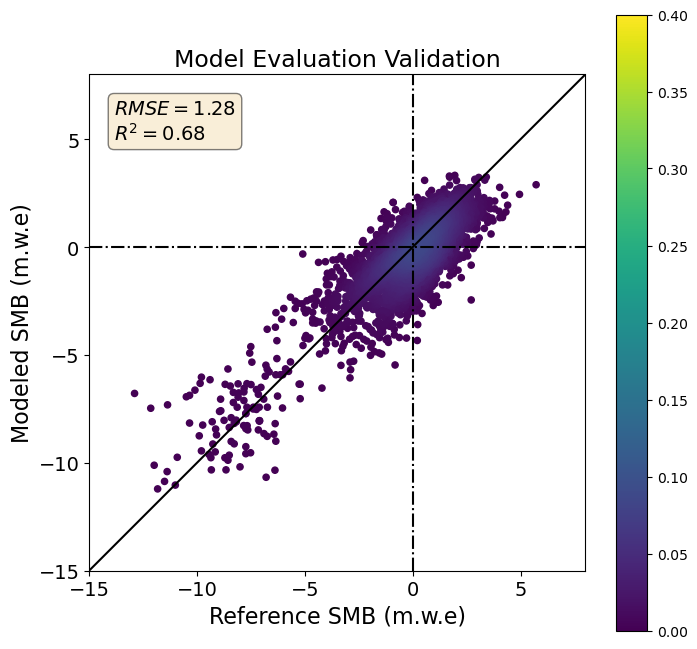

In [11]:
# Train model
best_model = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

### Training with temperature, precipitation and topographical features including latitude and longitude

In [12]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [13]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

df_train_X_s = df_train.drop(drop_cols, axis=1)
df_train_y_s = df_train[['balance_netto']]

#df_test_X = df_test.drop(drop_cols, axis=1)
#df_test_y = df_test[['balance_netto']]

In [18]:
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get shuffled glacier ids
gp_s = np.array(df_train_s['BREID'].values)

In [19]:
# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split dataset into groups based on shuffled glacier ids.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [39]:
# View order of sorted glaciers
df_gp_s = pd.DataFrame(gp_s)
df_gp_s[0].unique()

array([2078, 3128, 2297, 1144, 2474, 1094, 3129,  675, 2514, 3137, 3126,
        596, 3133, 2968, 2772, 2743, 1092, 2148, 3138, 2597], dtype=int64)

In [67]:
# X_train_s.shape is 2738
# gp_s.shape is 2738
# splits_s 0 is 1825 train, 913 test (Nigardsbreen as test)
# splits_s 1 is 2108 train, 630 test
# splits_s 2 is 2337 train, 401 test
# splits_s 3 is 2343 train, 395 test
# splits_s 4 is 2339 train, 399 test
# Sum of test obs: 913+630+401+395+399=2738

In [75]:
print('Train, fold 1: ', np.unique(gp_s[splits_s[0][0]]))
print('Test, fold 1: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[1][0]]))
print('Test, fold 2: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[2][0]]))
print('Test, fold 3: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[3][0]]))
print('Test, fold 4: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 5: ', np.unique(gp_s[splits_s[4][0]]))
print('Test, fold 5: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 1:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Test, fold 1:  [2297]
Train, fold 2:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Test, fold 2:  [2078]
Train, fold 3:  [ 596  675 1144 2078 2148 2297 2474 2514 2597 2743 3126 3128 3129 3137]
Test, fold 3:  [1092 1094 2772 2968 3133 3138]
Train, fold 4:  [ 596 1092 1094 1144 2078 2148 2297 2514 2772 2968 3126 3128 3133 3138]
Test, fold 4:  [ 675 2474 2597 2743 3129 3137]
Train, fold 5:  [ 675 1092 1094 2078 2297 2474 2597 2743 2772 2968 3129 3133 3137 3138]
Test, fold 5:  [ 596 1144 2148 2514 3126 3128]


In [21]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.360476300498321
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 400}
Cross validation scores per fold:  [-0.39687    -0.43001743 -0.28337383 -0.31460083 -0.37751942]
Mean cross validation score:  -0.360476300498321
Standard deviation:  0.05385218323480411


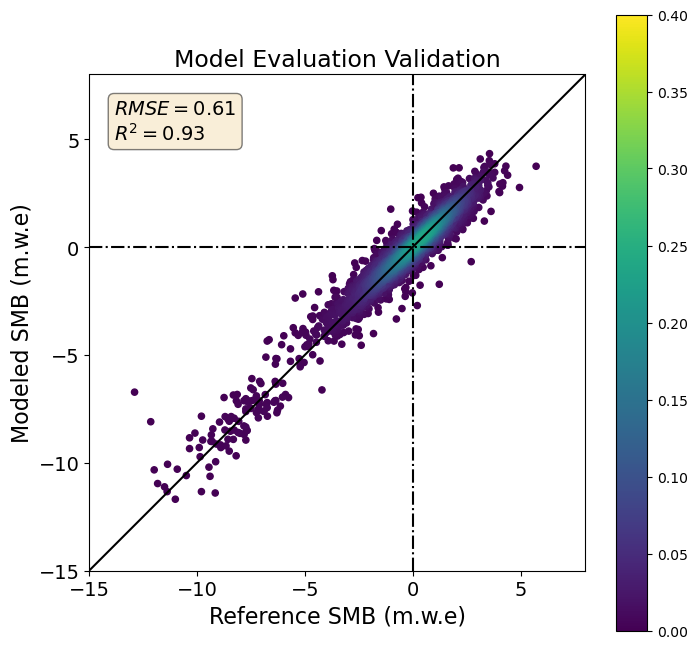

In [22]:
# Train model
best_model = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

In [27]:
max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

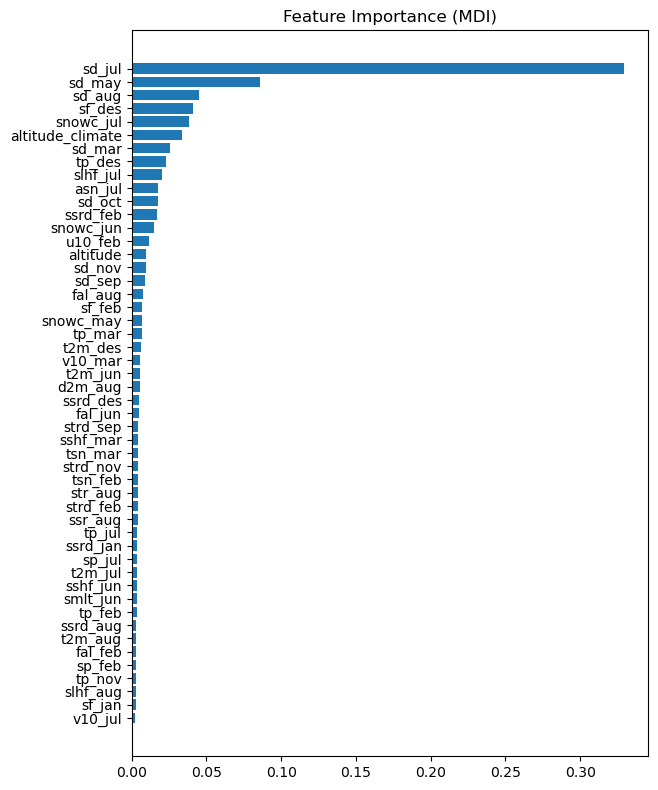

In [28]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [76]:
# USING FEWER TREES
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 196 candidates, totalling 980 fits
Cross validation score:  -0.36833093765765496
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 200}
Cross validation scores per fold:  [-0.40274186 -0.44208144 -0.29298158 -0.32324916 -0.38060065]
Mean cross validation score:  -0.36833093765765496
Standard deviation:  0.053821347631486244


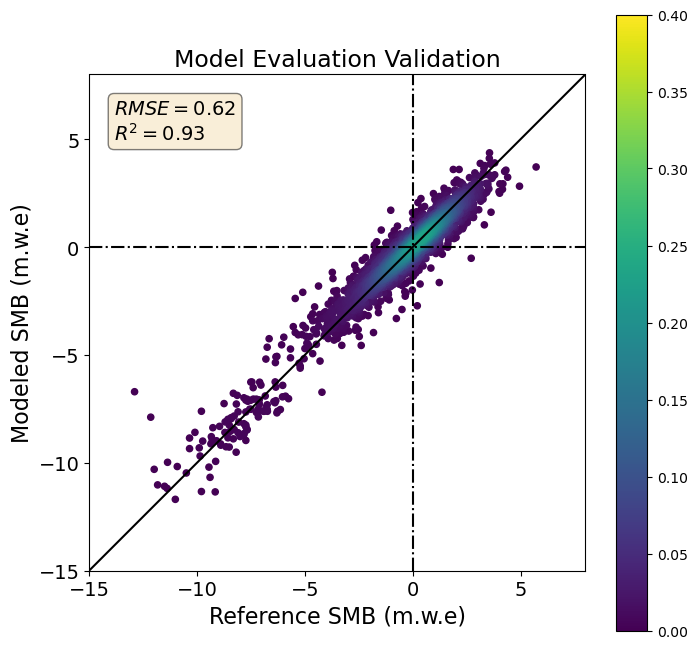

In [77]:
# Train model
best_model_few_trees = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

In [78]:
df_test.shape

(1101, 302)

0.2867934357905705